In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_dir = "/Users/Jasmine/Downloads/Garbage classification/Garbage classification"

classes = os.listdir(data_dir)
print(classes)

Recyclable_Or_Not = {"paper" : True,
                     "trash" : False,
                     "metal" : True,
                     "plastic" : True,
                     "glass" : True,
                     "cardboard" : True}

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


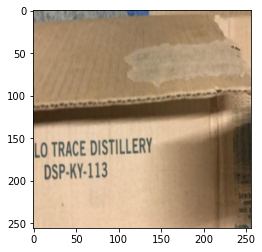

In [5]:
img, label = dataset[12]
show_sample(img, label)

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

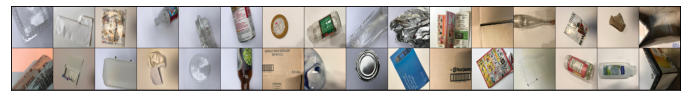

In [11]:
show_batch(train_dl)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

C:\Users\Jasmine\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jasmine\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(ResNet(), device)

In [19]:
evaluate(model, val_dl)

{'val_loss': 1.8006811141967773, 'val_acc': 0.1371527761220932}

Let's start training the model:

In [20]:
Model_Path = "recyclable_model.pth"
if os.path.exists(Model_Path):
    print(f"Model found at '{Model_Path}'. Loading the model and skipping training...")
    model = torch.load(Model_Path)
    model.eval()  # Set to evaluation mode
else:
    print(f"No model found at '{Model_Path}'. Proceeding with training...")
    num_epochs = 8
    opt_func = torch.optim.Adam
    lr = 5.5e-5
    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
    torch.save(model, Model_Path)
    print(f"Training complete. Model saved to '{Model_Path}'.")

Model found at 'recyclable_model.pth'. Loading the model and skipping training...


# Visualizing Predictions:

In [21]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


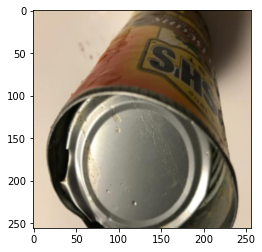

In [22]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


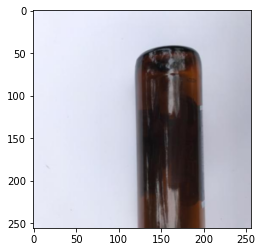

In [23]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


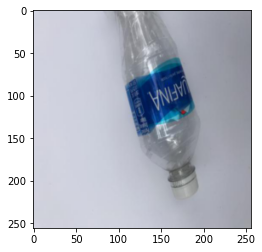

In [24]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

In [25]:
loaded_model = model

In [26]:
from PIL import Image
from pathlib import Path

def predict_external_image(image):
    example_image = transformations(image)
    response = predict_image(example_image, loaded_model)
    print("=========================================================================")
    print("The image resembles:", response)
    print("Is it recyclable? ", Recyclable_Or_Not[response])
    return Recyclable_Or_Not[response]

def predict_external_image2(image_path):
    image = Image.open(Path(image_path))
    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    response = predict_image(example_image, loaded_model)
    print("The image resembles:", response)
    print("Is it recyclable? ", Recyclable_Or_Not[response])
    return Recyclable_Or_Not[response]

The image resembles: plastic
Is it recyclable?  True
True


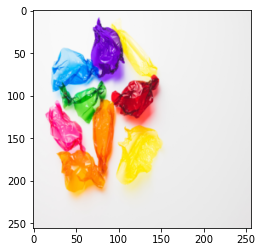

In [27]:
a = predict_external_image2("/Users/Jasmine/Downloads/CNN_Model/CNN_Model/Test_Images/candy-wrapper1.jpg")
print(a)

The image resembles: metal
Is it recyclable?  True
True


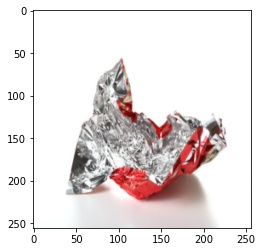

In [28]:
y = predict_external_image2("/Users/Jasmine/Downloads/CNN_Model/CNN_Model/Test_Images/candy-wrapper2.jpg")
print(y)

The image resembles: paper
Is it recyclable?  True
True


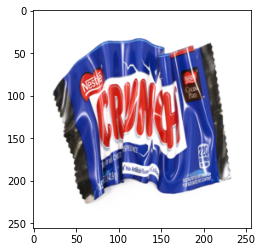

In [29]:
b = predict_external_image2("/Users/Jasmine/Downloads/CNN_Model/CNN_Model/Test_Images/candy-wrapper3.jpg")
print(b)

The image resembles: plastic
Is it recyclable?  True
True


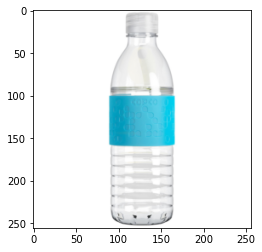

In [30]:
c = predict_external_image2("/Users/Jasmine/Downloads/CNN_Model/CNN_Model/Test_Images/plastic-water-bottle.jpg")
print(c)

The image resembles: metal
Is it recyclable?  True
True


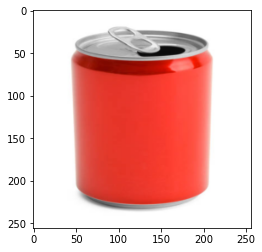

In [31]:
w = predict_external_image2("/Users/Jasmine/Downloads/CNN_Model/CNN_Model/Test_Images/metal-can2.jpg")
print(w)

In [32]:
# Create a Flask App:

In [ ]:
!pip install flask flask-cors pyngrok

from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok

# Initialize Flask app
app = Flask(__name__)
CORS(app)  # Enable CORS for cross-origin requests

# Define an inference endpoint
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    # Retrieve the inputted image file
    file = request.files['file']

    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    # Open the image file
    input_image = Image.open(file.stream).convert('RGB')

    # "prediction" is a Boolean value True or False
    prediction = predict_external_image(input_image)

    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run(host="0.0.0.0", port = 10000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.0.104:10000/ (Press CTRL+C to quit)
127.0.0.1 - - [08/Dec/2024 13:56:40] "POST /predict HTTP/1.1" 200 -


The image resembles: metal
Is it recyclable?  True


127.0.0.1 - - [08/Dec/2024 14:10:32] "POST /predict HTTP/1.1" 200 -


The image resembles: metal
Is it recyclable?  True


192.168.56.1 - - [08/Dec/2024 14:11:04] "POST /predict HTTP/1.1" 200 -


The image resembles: metal
Is it recyclable?  True


192.168.56.1 - - [08/Dec/2024 14:46:48] "POST /predict HTTP/1.1" 200 -


The image resembles: plastic
Is it recyclable?  True


192.168.56.1 - - [08/Dec/2024 14:53:53] "POST /predict HTTP/1.1" 200 -


The image resembles: plastic
Is it recyclable?  True


192.168.56.1 - - [08/Dec/2024 15:16:10] "POST /predict HTTP/1.1" 200 -


The image resembles: trash
Is it recyclable?  False


192.168.56.1 - - [08/Dec/2024 15:16:48] "POST /predict HTTP/1.1" 200 -


The image resembles: metal
Is it recyclable?  True


In [ ]:
'''
% curl -X POST -F "file=@/Users/vedantsawal/Desktop/Test_Images/metal-can2.jpg" http://127.0.0.1:10000/predict
curl -X POST -F "file=@C:\Users\Jasmine\Downloads\CNN_Model\CNN_Model\Test_Images\metal-can2.jpg" http://127.0.0.1:10000/predict
'''